In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gender-age-and-emotion-detection-from-voice:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1375808%2F2283633%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240604%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240604T173441Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dadd6ac205c862a65d949d4d9bf285a225856aee539ce3fbc24a12ac86ccb5a1a03d06cc26861d97183b4f405cf0bcd88dab1d6d9a9507ba7153d7f750f1725786da2a1396154fd824de0477a8f8420bdfb52eff47a4d3daa67cf4e221f309255d8288aef723634579cadcd3c7314e20d2cf952dedd6a08fcf193113074ecedda31140773b080248ca428110ec5521189f668db51d6085d240ec3cd1c08fa73931f2c9755f3f0efdad285768894b049639ee05e64df75e9f6fad0be96053ab711edec4109d829dd68eefc21617cd32683fda2e5a69144839fabc221891d4dc9a9d8491c3b2d7d7fa9d23385e07b998bf263216fff81d703ec518da1e181e165fb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 967820 bytes downloaded
Downloaded and uncompressed: gender-age-and-emotion-detection-from-voice
Data source import complete.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# ***Gender Detection***

In [ ]:
df = pd.read_csv('../input/gender-age-and-emotion-detection-from-voice/cleaned_gender.csv')

In [ ]:
df.head()

,Unnamed: 0,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,66,0.133338,0.069304,0.107668,0.089192,0.195267,0.106075,3.043456,13.694173,0.929512,...,0.133338,0.121968,0.047337,0.277457,0.822656,0.0,4.687500,4.687500,0.076296,male
1,84,0.137433,0.058518,0.112037,0.092841,0.200079,0.107238,2.807995,12.776650,0.911080,...,0.137433,0.111204,0.047151,0.277457,1.313384,0.0,6.046875,6.046875,0.135811,male
2,85,0.142227,0.065447,0.112242,0.093455,0.202909,0.109455,2.380899,9.942833,0.936040,...,0.142227,0.118711,0.047013,0.275862,0.593750,0.0,6.539062,6.539062,0.096102,male
3,87,0.133325,0.072849,0.113360,0.082861,0.203753,0.120892,1.904123,7.799218,0.958362,...,0.133325,0.116200,0.047105,0.279070,0.424922,0.0,5.812500,5.812500,0.081880,male
4,88,0.130487,0.070407,0.113418,0.076098,0.196188,0.120089,1.820873,8.561101,0.969568,...,0.130487,0.114802,0.047151,0.279070,0.198070,0.0,1.078125,1.078125,0.131579,male


In [ ]:
df=df.drop([df.columns[0]],axis=1)
df.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')

In [ ]:
print(df.isnull().sum())

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64


In [ ]:
df.shape

(4361, 21)

In [ ]:
df.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000
mean,0.186093,0.057006,0.190335,0.145796,0.230877,0.085081,1.971404,7.933659,0.915496,0.443468,0.185193,0.186093,0.130606,0.047334,0.277241,0.944215,0.016252,7.105706,7.089454,0.101832
std,0.019862,0.009515,0.026870,0.031776,0.018412,0.028191,0.579158,3.329032,0.025962,0.121583,0.055095,0.019862,0.016937,0.000405,0.002250,0.398433,0.045230,2.963021,2.963914,0.037590
min,0.130253,0.031227,0.107668,0.057482,0.177122,0.020521,0.550830,2.377435,0.838816,0.141281,0.002527,0.130253,0.093660,0.046921,0.271186,0.071470,0.000000,0.375000,0.375000,0.005507
25%,0.172234,0.050947,0.171007,0.122285,0.218621,0.059621,1.546014,5.363785,0.898416,0.355402,0.135029,0.172234,0.118378,0.047013,0.275862,0.641129,0.000000,5.109375,5.109375,0.074496
50%,0.184996,0.058363,0.191987,0.140107,0.232547,0.092520,1.917493,7.170027,0.918524,0.440672,0.192089,0.184996,0.126001,0.047198,0.277457,0.900000,0.000000,6.515625,6.492188,0.097698
75%,0.199711,0.063295,0.210788,0.168432,0.244517,0.108387,2.371233,9.873117,0.934720,0.530726,0.227678,0.199711,0.139656,0.047525,0.279070,1.192127,0.000000,9.140625,9.140625,0.126405
max,0.241377,0.082588,0.257051,0.235086,0.270893,0.150842,3.600165,17.922685,0.973249,0.785258,0.280000,0.241377,0.178343,0.048632,0.279070,2.102571,0.351562,15.210938,15.210938,0.208333


In [ ]:
df.label.value_counts()

label
male      3343
female    1018
Name: count, dtype: int64

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4361 entries, 0 to 4360
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  4361 non-null   float64
 1   sd        4361 non-null   float64
 2   median    4361 non-null   float64
 3   Q25       4361 non-null   float64
 4   Q75       4361 non-null   float64
 5   IQR       4361 non-null   float64
 6   skew      4361 non-null   float64
 7   kurt      4361 non-null   float64
 8   sp.ent    4361 non-null   float64
 9   sfm       4361 non-null   float64
 10  mode      4361 non-null   float64
 11  centroid  4361 non-null   float64
 12  meanfun   4361 non-null   float64
 13  minfun    4361 non-null   float64
 14  maxfun    4361 non-null   float64
 15  meandom   4361 non-null   float64
 16  mindom    4361 non-null   float64
 17  maxdom    4361 non-null   float64
 18  dfrange   4361 non-null   float64
 19  modindx   4361 non-null   float64
 20  label     4361 non-null   obje

In [ ]:
dict = {'label':{'male':1,'female':0}}
df.replace(dict,inplace = True)
X = df.loc[:, df.columns != 'label']
y = df.loc[:,'label']

<Axes: >

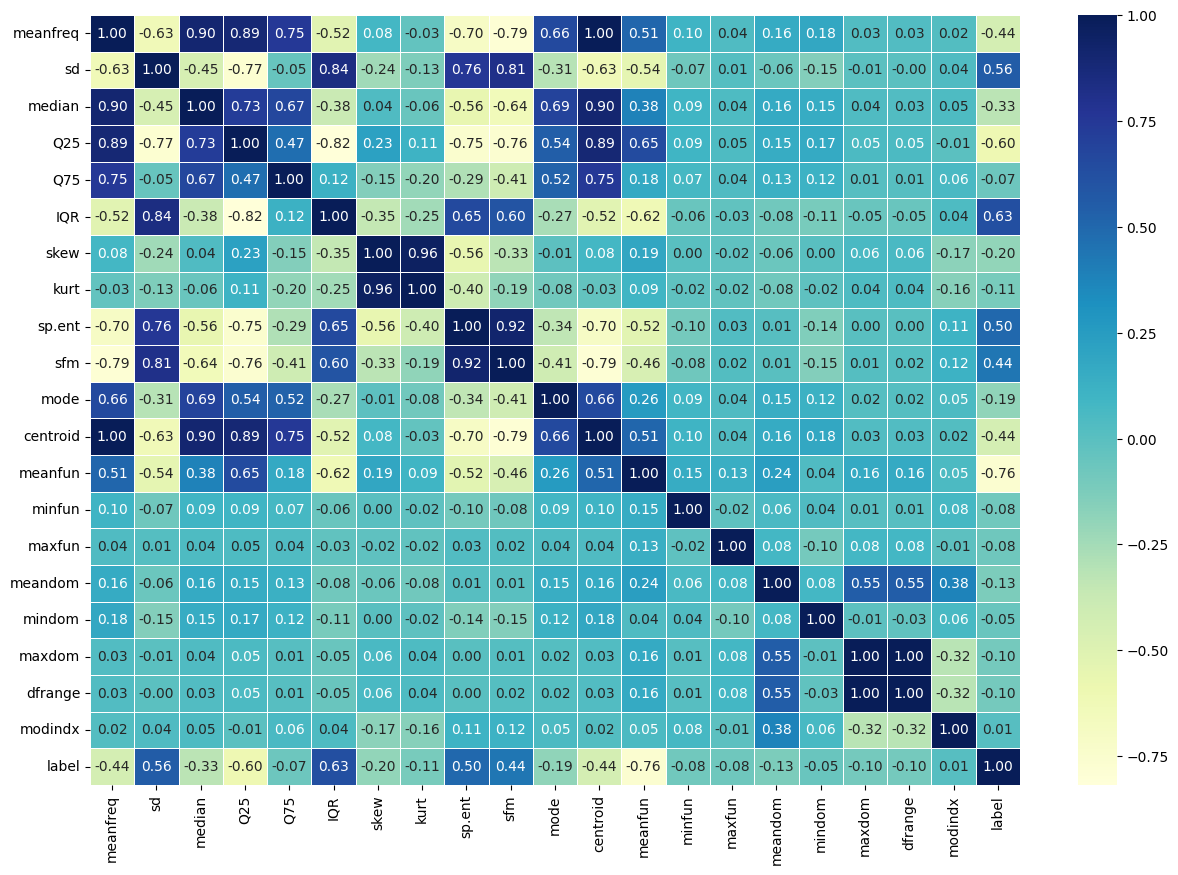

In [ ]:
corr_matrix=df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,
           annot=True,
           linewidths=0.5,
           fmt=".2f",
           cmap="YlGnBu")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model_acc = []

In [ ]:
svm_c = 1000
svm_gamma = 0.01

dtc_md = 5

rfc_M = 8
rfc_d = 8
rfc_m = 6

In [ ]:
model_acc = []

In [ ]:
SVM_model = SVC(C=svm_c, gamma=svm_gamma).fit(X_train, y_train)
train_acc = SVM_model.score(X_train, y_train)
test_acc = SVM_model.score(X_test, y_test)
m = 'SVM'
model_acc.append([m, train_acc, test_acc])

DTC_model = DecisionTreeClassifier(max_depth=dtc_md).fit(X_train, y_train)
train_acc = DTC_model.score(X_train, y_train)
test_acc = DTC_model.score(X_test, y_test)
m = 'Decision Tree Classifier'
model_acc.append([m, train_acc, test_acc])

RFC_model = RandomForestClassifier(n_estimators=rfc_M, max_features=rfc_d, max_depth=rfc_m, random_state=0).fit(X_train, y_train)
train_acc = RFC_model.score(X_train, y_train)
test_acc = RFC_model.score(X_test, y_test)
m = 'Random Forest Classifier'
model_acc.append([m, train_acc, test_acc])

In [ ]:
print("Feature importance of Decision Tree Classifier: ")
np.array([X.columns.values.tolist(), list(DTC_model.feature_importances_)]).T

Feature importance of Decision Tree Classifier: 


array([['meanfreq', '0.0'],
       ['sd', '0.0799383429003385'],
       ['median', '0.006045386810806264'],
       ['Q25', '0.020090855579078283'],
       ['Q75', '0.006669808554173385'],
       ['IQR', '0.0212979242480695'],
       ['skew', '0.0'],
       ['kurt', '0.001999241995616145'],
       ['sp.ent', '0.005848042625685133'],
       ['sfm', '0.008267675434587462'],
       ['mode', '0.005890623737083285'],
       ['centroid', '0.0'],
       ['meanfun', '0.8169967246685979'],
       ['minfun', '0.0'],
       ['maxfun', '0.0'],
       ['meandom', '0.007810036328801358'],
       ['mindom', '0.0'],
       ['maxdom', '0.012153286868087613'],
       ['dfrange', '0.0'],
       ['modindx', '0.006992050249075078']], dtype='<U32')

Text(0.5, 1.0, 'Feature Importance')

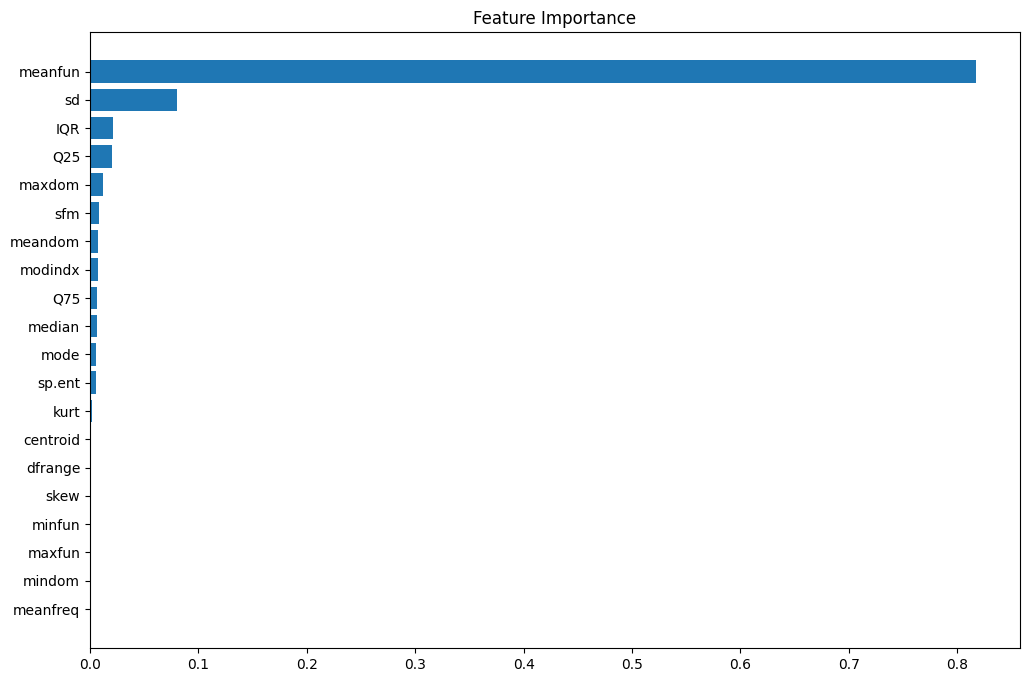

In [ ]:
importances = DTC_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), df.columns[indices])
plt.title('Feature Importance')

In [ ]:
print("Feature importance of Random Forest Classifier: ")
np.array([X.columns.values.tolist(), list(RFC_model.feature_importances_)]).T

Feature importance of Random Forest Classifier: 


array([['meanfreq', '0.006154263874361972'],
       ['sd', '0.17231292175351184'],
       ['median', '0.014000303149405117'],
       ['Q25', '0.07457759985440639'],
       ['Q75', '0.008117732357727985'],
       ['IQR', '0.08221292423832847'],
       ['skew', '0.00682363320482711'],
       ['kurt', '0.006766143565773939'],
       ['sp.ent', '0.006242147818896876'],
       ['sfm', '0.007914358098167155'],
       ['mode', '0.008277804086984766'],
       ['centroid', '0.005241016312456701'],
       ['meanfun', '0.5611368470841019'],
       ['minfun', '0.0035221686302718603'],
       ['maxfun', '0.00303442628649492'],
       ['meandom', '0.006991766075138902'],
       ['mindom', '0.0014744008530911807'],
       ['maxdom', '0.009567407459620572'],
       ['dfrange', '0.010912127225196197'],
       ['modindx', '0.004720008071236234']], dtype='<U32')

Text(0.5, 1.0, 'Feature Importance')

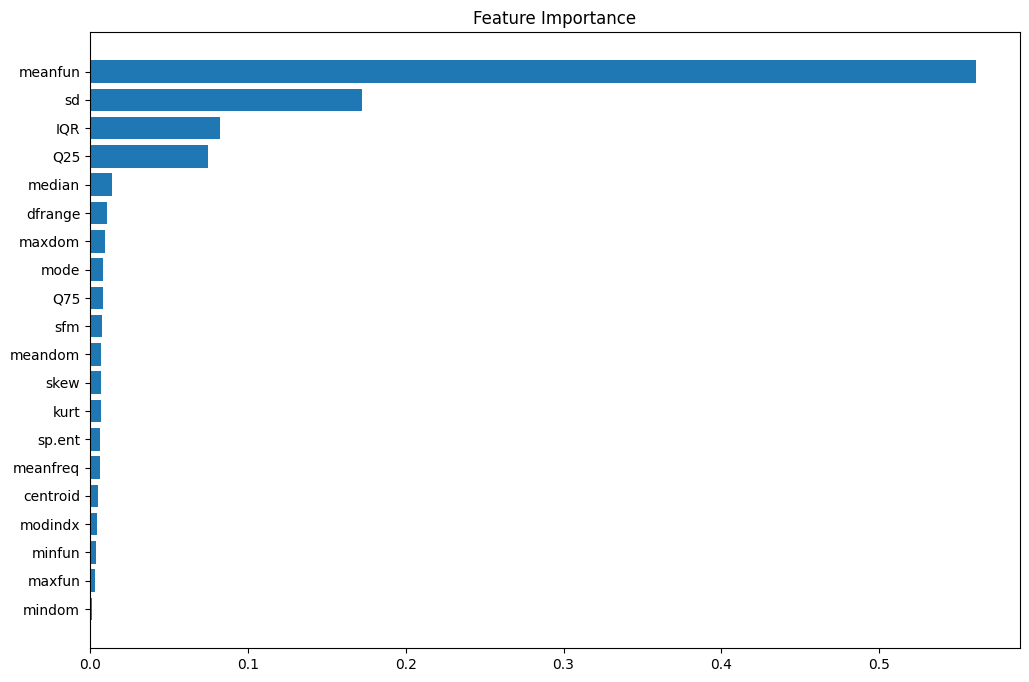

In [ ]:
importances = RFC_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), df.columns[indices])
plt.title('Feature Importance')

In [ ]:
result = pd.DataFrame(model_acc, columns=['Model', 'Training Accuracy', 'Validation Accuracy'])
result[['Model', 'Training Accuracy', 'Validation Accuracy']]

,Model,Training Accuracy,Validation Accuracy
0,SVM,0.935168,0.944088
1,Decision Tree Classifier,0.948624,0.951421
2,Random Forest Classifier,0.952599,0.948671


In [ ]:
df_new = df[['meanfun', 'sd', 'Q25', 'IQR','mode','median','label']]
df_new.head()

,meanfun,sd,Q25,IQR,mode,median,label
0,0.121968,0.069304,0.089192,0.106075,0.086962,0.107668,1
1,0.111204,0.058518,0.092841,0.107238,0.101332,0.112037,1
2,0.118711,0.065447,0.093455,0.109455,0.106545,0.112242,1
3,0.116200,0.072849,0.082861,0.120892,0.108583,0.113360,1
4,0.114802,0.070407,0.076098,0.120089,0.101534,0.113418,1


In [ ]:
X = df_new.loc[:, df_new.columns != 'label']
y = df_new.loc[:,'label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
feat_rf = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=0)
feat_his = feat_rf.fit(X_train,y_train)

In [ ]:
print(feat_his.score(X_train,y_train))
print(feat_his.score(X_test,y_test))

1.0
0.9266727772685609


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

anova_filter = SelectKBest(f_classif, k=6)
clf = RandomForestClassifier(n_estimators=rfc_M, max_features=6, max_depth=rfc_m, random_state=0)
anova_svm = make_pipeline(anova_filter, clf)
anova_svm.fit(X_train, y_train)

Pipeline(steps=[('selectkbest', SelectKBest(k=6)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=6, max_features=6,
                                        n_estimators=8, random_state=0))])

In [ ]:
print(anova_svm.score(X_train,y_train))
print(anova_svm.score(X_test,y_test))

0.9614678899082569
0.925756186984418


# ***Age Detection***

In [ ]:
df = pd.read_csv('../input/gender-age-and-emotion-detection-from-voice/cleaned_age.csv')

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,66,67,0.133338,0.069304,0.107668,0.089192,0.195267,0.106075,3.043456,13.694173,...,0.133338,0.121968,0.047337,0.277457,0.822656,0.0,4.687500,4.687500,0.076296,young
1,84,85,0.137433,0.058518,0.112037,0.092841,0.200079,0.107238,2.807995,12.776650,...,0.137433,0.111204,0.047151,0.277457,1.313384,0.0,6.046875,6.046875,0.135811,young
2,85,86,0.142227,0.065447,0.112242,0.093455,0.202909,0.109455,2.380899,9.942833,...,0.142227,0.118711,0.047013,0.275862,0.593750,0.0,6.539062,6.539062,0.096102,matured
3,87,88,0.133325,0.072849,0.113360,0.082861,0.203753,0.120892,1.904123,7.799218,...,0.133325,0.116200,0.047105,0.279070,0.424922,0.0,5.812500,5.812500,0.081880,young
4,88,89,0.130487,0.070407,0.113418,0.076098,0.196188,0.120089,1.820873,8.561101,...,0.130487,0.114802,0.047151,0.279070,0.198070,0.0,1.078125,1.078125,0.131579,matured


In [ ]:
df=df.drop([df.columns[0], df.columns[1]],axis=1)
df.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')

In [ ]:
print(df.isnull().sum())

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64


In [ ]:
df.shape

(4361, 21)

In [ ]:
df.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000
mean,0.186093,0.057006,0.190335,0.145796,0.230877,0.085081,1.971404,7.933659,0.915496,0.443468,0.185193,0.186093,0.130606,0.047334,0.277241,0.944215,0.016252,7.105706,7.089454,0.101832
std,0.019862,0.009515,0.026870,0.031776,0.018412,0.028191,0.579158,3.329032,0.025962,0.121583,0.055095,0.019862,0.016937,0.000405,0.002250,0.398433,0.045230,2.963021,2.963914,0.037590
min,0.130253,0.031227,0.107668,0.057482,0.177122,0.020521,0.550830,2.377435,0.838816,0.141281,0.002527,0.130253,0.093660,0.046921,0.271186,0.071470,0.000000,0.375000,0.375000,0.005507
25%,0.172234,0.050947,0.171007,0.122285,0.218621,0.059621,1.546014,5.363785,0.898416,0.355402,0.135029,0.172234,0.118378,0.047013,0.275862,0.641129,0.000000,5.109375,5.109375,0.074496
50%,0.184996,0.058363,0.191987,0.140107,0.232547,0.092520,1.917493,7.170027,0.918524,0.440672,0.192089,0.184996,0.126001,0.047198,0.277457,0.900000,0.000000,6.515625,6.492188,0.097698
75%,0.199711,0.063295,0.210788,0.168432,0.244517,0.108387,2.371233,9.873117,0.934720,0.530726,0.227678,0.199711,0.139656,0.047525,0.279070,1.192127,0.000000,9.140625,9.140625,0.126405
max,0.241377,0.082588,0.257051,0.235086,0.270893,0.150842,3.600165,17.922685,0.973249,0.785258,0.280000,0.241377,0.178343,0.048632,0.279070,2.102571,0.351562,15.210938,15.210938,0.208333


In [ ]:
df.label.value_counts()

label
matured    1983
young      1816
old         562
Name: count, dtype: int64

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4361 entries, 0 to 4360
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  4361 non-null   float64
 1   sd        4361 non-null   float64
 2   median    4361 non-null   float64
 3   Q25       4361 non-null   float64
 4   Q75       4361 non-null   float64
 5   IQR       4361 non-null   float64
 6   skew      4361 non-null   float64
 7   kurt      4361 non-null   float64
 8   sp.ent    4361 non-null   float64
 9   sfm       4361 non-null   float64
 10  mode      4361 non-null   float64
 11  centroid  4361 non-null   float64
 12  meanfun   4361 non-null   float64
 13  minfun    4361 non-null   float64
 14  maxfun    4361 non-null   float64
 15  meandom   4361 non-null   float64
 16  mindom    4361 non-null   float64
 17  maxdom    4361 non-null   float64
 18  dfrange   4361 non-null   float64
 19  modindx   4361 non-null   float64
 20  label     4361 non-null   obje

In [ ]:
dict = {'label':{'old':2,'matured':1,'young':0}}
df.replace(dict,inplace = True)
X = df.loc[:, df.columns != 'label']
y = df.loc[:,'label']

<Axes: >

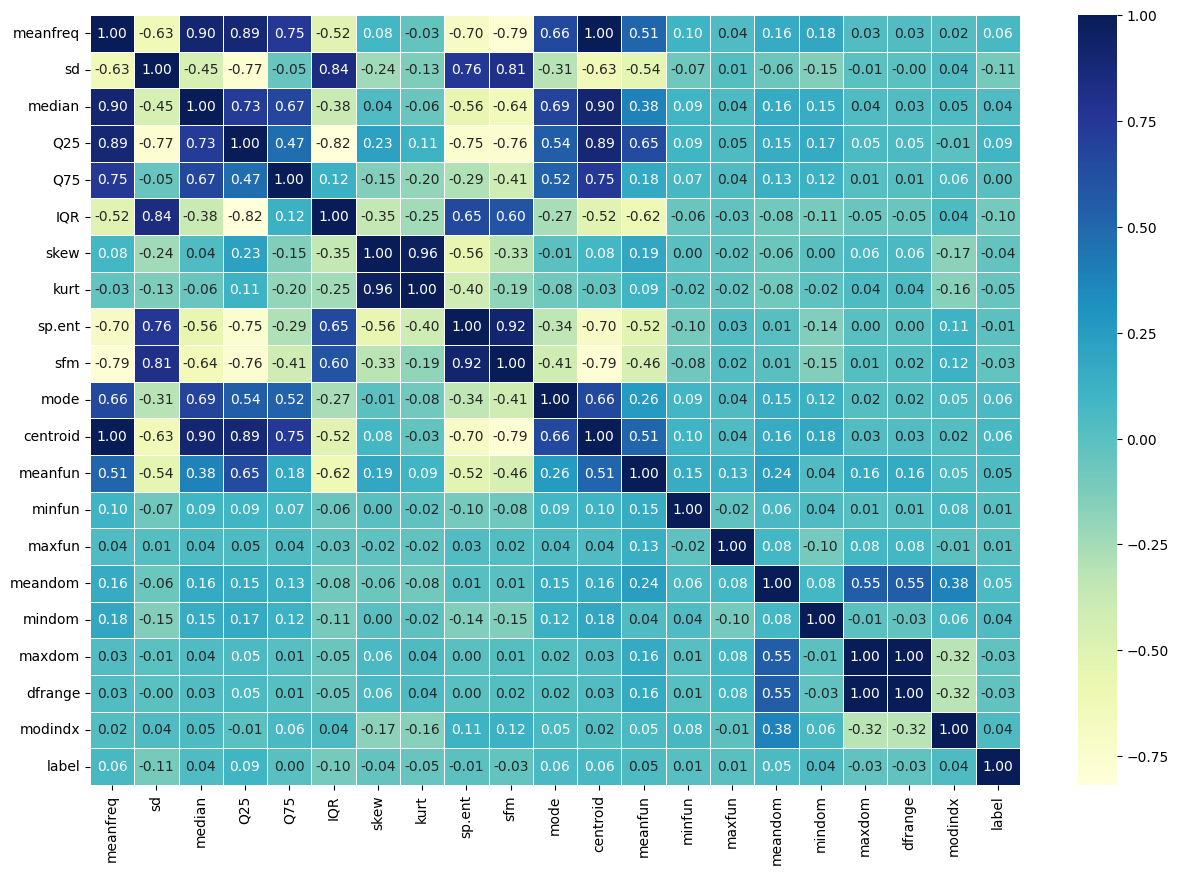

In [ ]:
corr_matrix=df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,
           annot=True,
           linewidths=0.5,
           fmt=".2f",
           cmap="YlGnBu")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model_acc = []

In [ ]:
svm_c = 10
svm_gamma = 0.1

dtc_md = 8

rfc_M = 14
rfc_d = 14
rfc_m = 16

In [ ]:
SVM_model = SVC(C=svm_c, gamma=svm_gamma).fit(X_train, y_train)
train_acc = SVM_model.score(X_train, y_train)
test_acc = SVM_model.score(X_test, y_test)
m = 'SVM'
model_acc.append([m, train_acc, test_acc])

DTC_model = DecisionTreeClassifier(max_depth=dtc_md).fit(X_train, y_train)
train_acc = DTC_model.score(X_train, y_train)
test_acc = DTC_model.score(X_test, y_test)
m = 'Decision Tree Classifier'
model_acc.append([m, train_acc, test_acc])

RFC_model = RandomForestClassifier(n_estimators=rfc_M, max_features=rfc_d, max_depth=rfc_m, random_state=0).fit(X_train, y_train)
train_acc = RFC_model.score(X_train, y_train)
test_acc = RFC_model.score(X_test, y_test)
m = 'Random Forest Classifier'
model_acc.append([m, train_acc, test_acc])

In [ ]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(DTC_model.feature_importances_)]).T

Feature importance: 


array([['meanfreq', '0.02825459956687026'],
       ['sd', '0.0776438006076664'],
       ['median', '0.008969786122536157'],
       ['Q25', '0.09208123647622082'],
       ['Q75', '0.05488479341014649'],
       ['IQR', '0.033152829408735845'],
       ['skew', '0.05998171593625181'],
       ['kurt', '0.03356020714774296'],
       ['sp.ent', '0.03178318970859371'],
       ['sfm', '0.1826440831170809'],
       ['mode', '0.06137711930064042'],
       ['centroid', '0.013704496434847831'],
       ['meanfun', '0.07891817883796495'],
       ['minfun', '0.02139674704315246'],
       ['maxfun', '0.006727204086126199'],
       ['meandom', '0.08107633643743813'],
       ['mindom', '0.0'],
       ['maxdom', '0.061923097474660724'],
       ['dfrange', '0.032251914856392325'],
       ['modindx', '0.03966866402693155']], dtype='<U32')

Text(0.5, 1.0, 'Feature Importance')

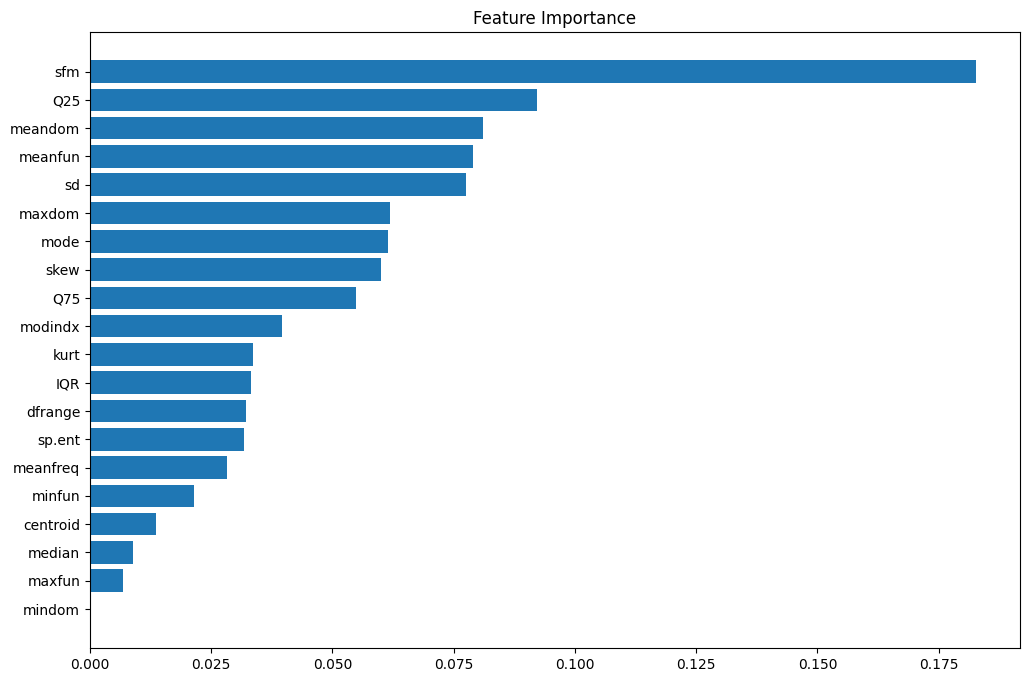

In [ ]:
importances = DTC_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), df.columns[indices])
plt.title('Feature Importance')

In [ ]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(RFC_model.feature_importances_)]).T

Feature importance: 


array([['meanfreq', '0.03337519868425065'],
       ['sd', '0.06714097120999794'],
       ['median', '0.0507179267135328'],
       ['Q25', '0.06667349711705511'],
       ['Q75', '0.0496671301675344'],
       ['IQR', '0.05551667009994437'],
       ['skew', '0.045937452975425556'],
       ['kurt', '0.042521799780113306'],
       ['sp.ent', '0.05541330550804736'],
       ['sfm', '0.08616314355232534'],
       ['mode', '0.05674461773595727'],
       ['centroid', '0.027354580654972635'],
       ['meanfun', '0.07057857926668548'],
       ['minfun', '0.04060792455898203'],
       ['maxfun', '0.0199230851338726'],
       ['meandom', '0.0653843612555016'],
       ['mindom', '0.008323505710385658'],
       ['maxdom', '0.05134617287232776'],
       ['dfrange', '0.04520089674940959'],
       ['modindx', '0.06140918025367839']], dtype='<U32')

Text(0.5, 1.0, 'Feature Importance')

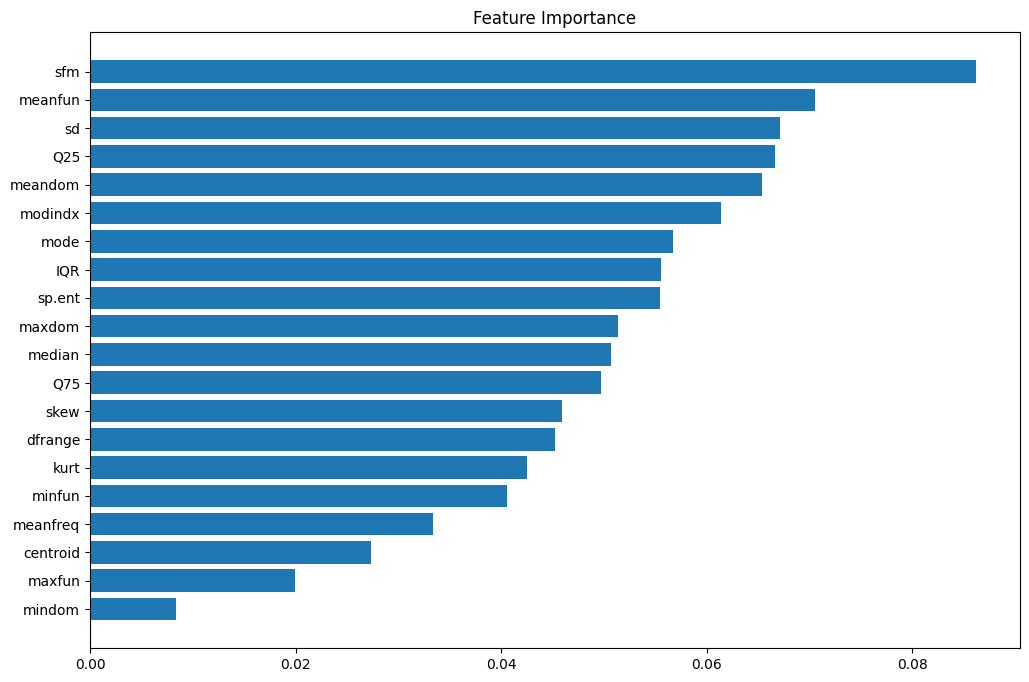

In [ ]:
importances = RFC_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), df.columns[indices])
plt.title('Feature Importance')

In [ ]:
result = pd.DataFrame(model_acc, columns=['Model', 'Training Accuracy', 'Validation Accuracy'])
result[['Model', 'Training Accuracy', 'Validation Accuracy']]

,Model,Training Accuracy,Validation Accuracy
0,SVM,0.567584,0.481210
1,Decision Tree Classifier,0.677982,0.516040
2,Random Forest Classifier,0.983792,0.548121


# ***Emotion Detection***

In [ ]:
df = pd.read_csv('../input/gender-age-and-emotion-detection-from-voice/cleaned_emotion.csv')

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,X,meanfreq,sd,median,Q25,Q75,IQR,skew,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0,1,1,0.181338,0.060495,0.187476,0.126197,0.233586,0.107389,0.869088,...,0.181338,0.137742,0.023022,0.271186,0.777344,0.085938,6.226562,6.140625,0.116586,sad
1,1,2,2,0.186897,0.062260,0.195070,0.130847,0.243987,0.113140,1.191767,...,0.186897,0.121811,0.018412,0.271186,0.930339,0.085938,4.000000,3.914062,0.144983,sad
2,2,3,3,0.189102,0.062901,0.204945,0.131422,0.249978,0.118556,1.312690,...,0.189102,0.123758,0.083333,0.262295,0.332386,0.085938,0.625000,0.539062,0.334783,sad
3,4,5,5,0.183036,0.060051,0.174115,0.129949,0.236967,0.107017,1.096409,...,0.183036,0.128469,0.044693,0.258065,1.012019,0.085938,5.468750,5.382812,0.304910,sad
4,5,6,6,0.168793,0.057910,0.156266,0.116783,0.216326,0.099543,1.386837,...,0.168793,0.109720,0.022472,0.235294,0.228795,0.093750,0.750000,0.656250,0.306777,sad


In [ ]:
df=df.drop([df.columns[0], df.columns[1], df.columns[2]],axis=1)
df.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')

In [ ]:
print(df.isnull().sum())

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64


In [ ]:
df.shape

(909, 21)

In [ ]:
df.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
mean,0.206170,0.051275,0.212524,0.177508,0.244574,0.067065,2.095407,8.336008,0.884311,0.298569,0.220830,0.206170,0.166384,0.032167,0.259240,0.791625,0.129787,4.224534,4.094747,0.204235
std,0.023133,0.014841,0.027557,0.038010,0.017223,0.029831,0.614903,3.511599,0.036912,0.134277,0.047916,0.023133,0.032946,0.018036,0.018766,0.318400,0.101413,1.966856,1.958441,0.070437
min,0.138892,0.024114,0.139472,0.046111,0.193367,0.020098,0.681156,2.657216,0.783243,0.074134,0.084523,0.138892,0.074660,0.015640,0.192771,0.107319,0.000000,0.234375,0.085938,0.009846
25%,0.185884,0.037961,0.191591,0.146098,0.232371,0.042470,1.628812,5.531592,0.854904,0.182142,0.195945,0.185884,0.141497,0.018328,0.250000,0.544271,0.000000,2.960938,2.781250,0.151972
50%,0.207456,0.049979,0.216077,0.184609,0.245731,0.057073,2.068654,7.563524,0.885243,0.281802,0.231820,0.207456,0.173804,0.024768,0.266667,0.765625,0.148438,4.500000,4.367188,0.194397
75%,0.226357,0.062497,0.233591,0.211461,0.259418,0.092380,2.504630,10.571021,0.917343,0.405891,0.263500,0.226357,0.192616,0.040921,0.275862,1.005729,0.210938,5.875000,5.734375,0.245702
max,0.250264,0.100239,0.264487,0.250455,0.274048,0.173421,3.800316,18.224444,0.959177,0.710205,0.280000,0.250264,0.228604,0.086957,0.275862,1.724888,0.500000,6.992188,6.992188,0.401399


In [ ]:
df.label.value_counts()

label
sad      314
angry    302
happy    293
Name: count, dtype: int64

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  909 non-null    float64
 1   sd        909 non-null    float64
 2   median    909 non-null    float64
 3   Q25       909 non-null    float64
 4   Q75       909 non-null    float64
 5   IQR       909 non-null    float64
 6   skew      909 non-null    float64
 7   kurt      909 non-null    float64
 8   sp.ent    909 non-null    float64
 9   sfm       909 non-null    float64
 10  mode      909 non-null    float64
 11  centroid  909 non-null    float64
 12  meanfun   909 non-null    float64
 13  minfun    909 non-null    float64
 14  maxfun    909 non-null    float64
 15  meandom   909 non-null    float64
 16  mindom    909 non-null    float64
 17  maxdom    909 non-null    float64
 18  dfrange   909 non-null    float64
 19  modindx   909 non-null    float64
 20  label     909 non-null    object

In [ ]:
dict = {'label':{'sad':0,'angry':1, 'happy':2}}
df.replace(dict,inplace = True)
X = df.loc[:, df.columns != 'label']
y = df.loc[:,'label']

<Axes: >

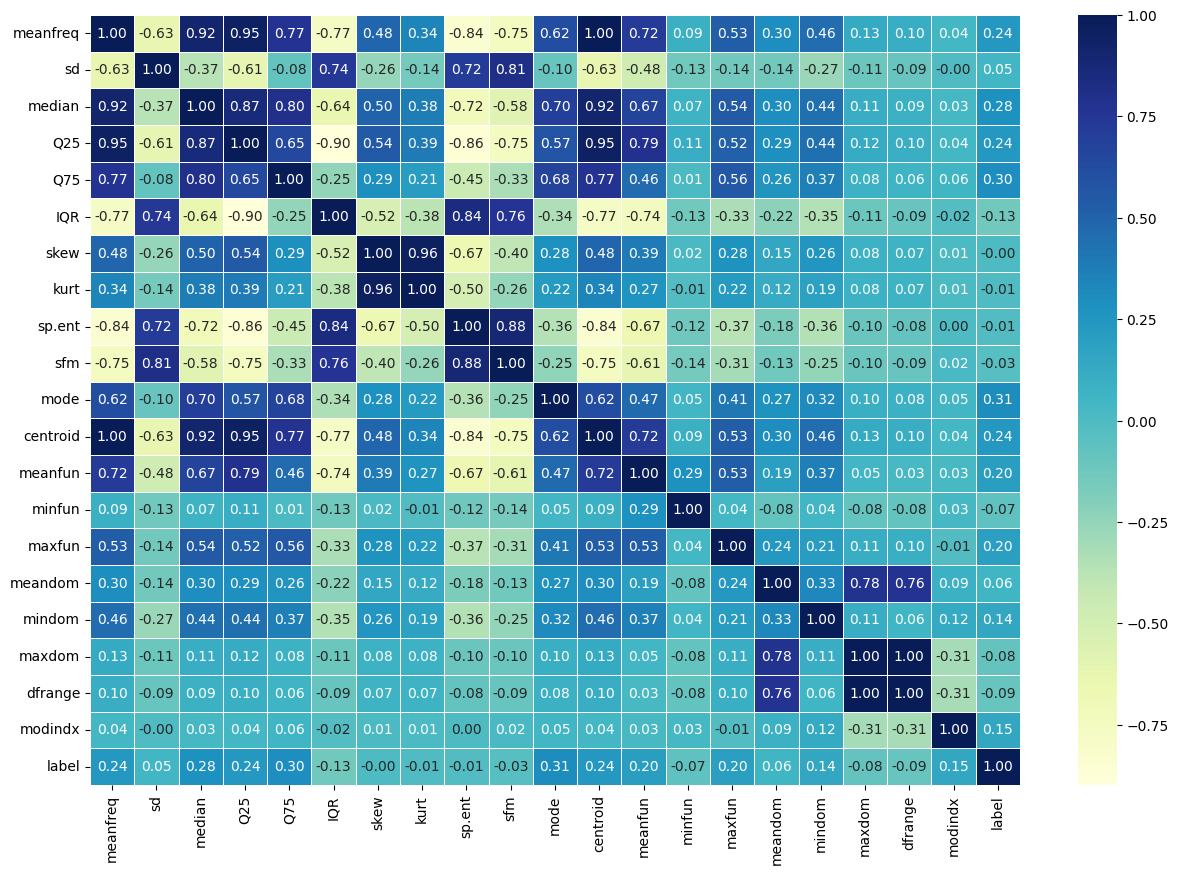

In [ ]:
corr_matrix=df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,
           annot=True,
           linewidths=0.5,
           fmt=".2f",
           cmap="YlGnBu")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model_acc = []

In [ ]:
svm_c = 1000
svm_gamma = 0.01

dtc_md = 4

rfc_M = 14
rfc_d = 8
rfc_m = 16

In [ ]:
SVM_model = SVC(C=svm_c, gamma=svm_gamma).fit(X_train, y_train)
train_acc = SVM_model.score(X_train, y_train)
test_acc = SVM_model.score(X_test, y_test)
m = 'SVM'
model_acc.append([m, train_acc, test_acc])

DTC_model = DecisionTreeClassifier(max_depth=dtc_md).fit(X_train, y_train)
train_acc = DTC_model.score(X_train, y_train)
test_acc = DTC_model.score(X_test, y_test)
m = 'Decision Tree Classifier'
model_acc.append([m, train_acc, test_acc])

RFC_model = RandomForestClassifier(n_estimators=rfc_M, max_features=rfc_d, max_depth=rfc_m, random_state=0).fit(X_train, y_train)
train_acc = RFC_model.score(X_train, y_train)
test_acc = RFC_model.score(X_test, y_test)
m = 'Random Forest Classifier'
model_acc.append([m, train_acc, test_acc])

In [ ]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(DTC_model.feature_importances_)]).T

Feature importance: 


array([['meanfreq', '0.0'],
       ['sd', '0.035035923105989006'],
       ['median', '0.0'],
       ['Q25', '0.20787663947289842'],
       ['Q75', '0.11070698567845094'],
       ['IQR', '0.030632729887066962'],
       ['skew', '0.0'],
       ['kurt', '0.03580441653268091'],
       ['sp.ent', '0.14181867396408712'],
       ['sfm', '0.09290192083591746'],
       ['mode', '0.07494122180449864'],
       ['centroid', '0.0'],
       ['meanfun', '0.0'],
       ['minfun', '0.0'],
       ['maxfun', '0.022016704148088897'],
       ['meandom', '0.18348990110477173'],
       ['mindom', '0.0'],
       ['maxdom', '0.0'],
       ['dfrange', '0.0'],
       ['modindx', '0.06477488346554991']], dtype='<U32')

Text(0.5, 1.0, 'Feature Importance')

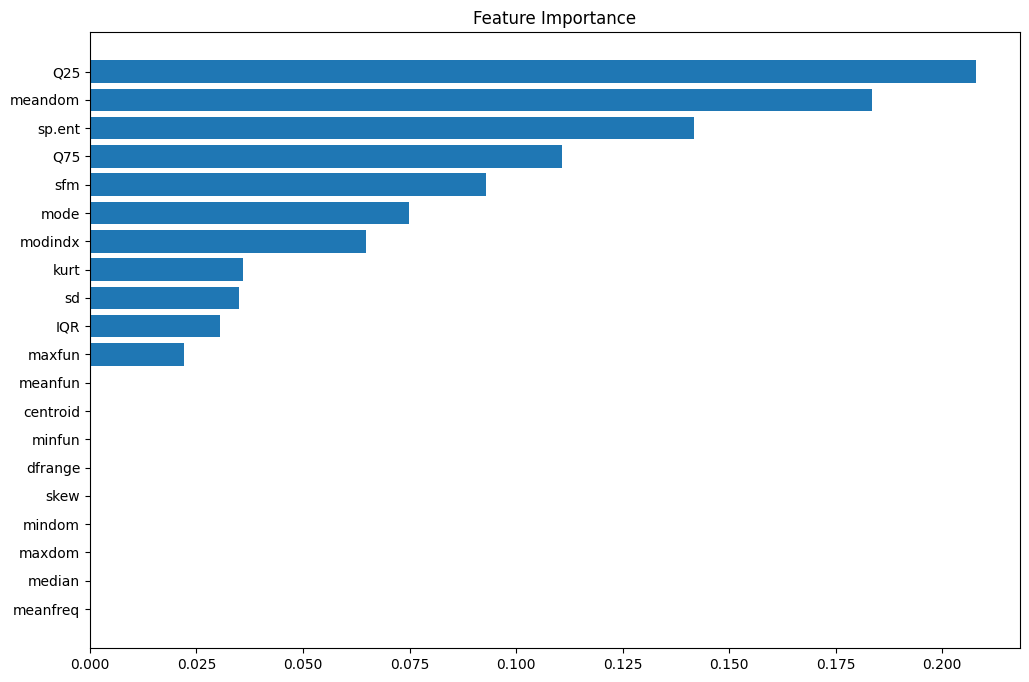

In [ ]:
importances = DTC_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), df.columns[indices])
plt.title('Feature Importance')

In [ ]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(RFC_model.feature_importances_)]).T

Feature importance: 


array([['meanfreq', '0.0365033990982076'],
       ['sd', '0.04833466298487689'],
       ['median', '0.03346815957216135'],
       ['Q25', '0.06858121667811239'],
       ['Q75', '0.07001409137776375'],
       ['IQR', '0.04865250471341006'],
       ['skew', '0.03349511675194325'],
       ['kurt', '0.03579697827153727'],
       ['sp.ent', '0.06711050076987234'],
       ['sfm', '0.059210265182217954'],
       ['mode', '0.07976359356840516'],
       ['centroid', '0.0416639766154724'],
       ['meanfun', '0.07833726871403024'],
       ['minfun', '0.03532385376391335'],
       ['maxfun', '0.022735816316880913'],
       ['meandom', '0.07961966234098031'],
       ['mindom', '0.02573423896072548'],
       ['maxdom', '0.053602242166176046'],
       ['dfrange', '0.03233824644859084'],
       ['modindx', '0.04971420570472246']], dtype='<U32')

Text(0.5, 1.0, 'Feature Importance')

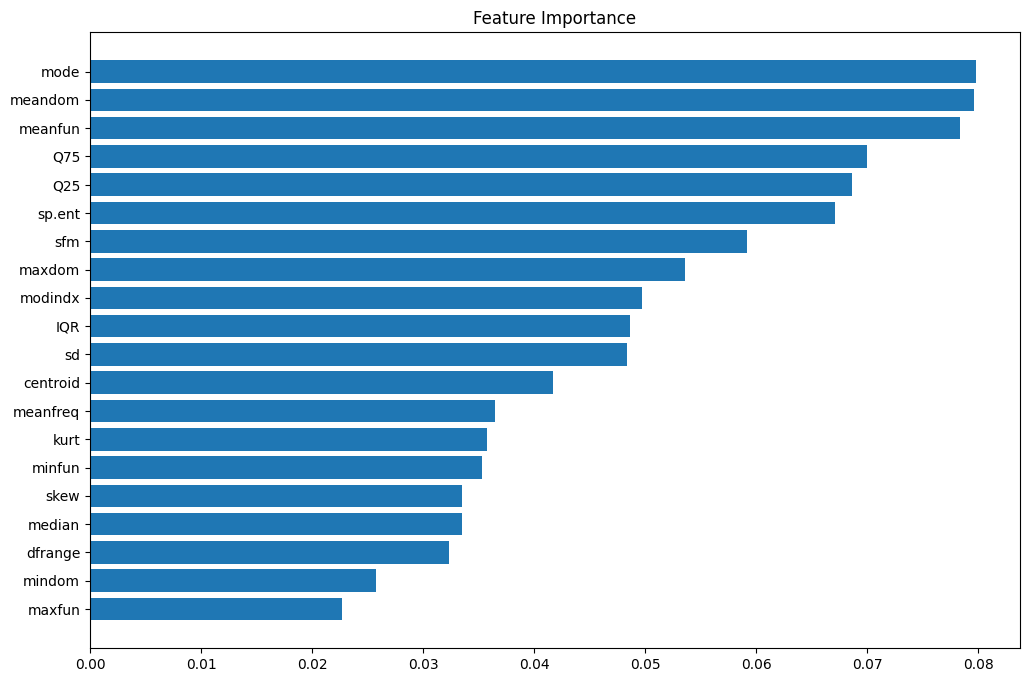

In [ ]:
importances = RFC_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), df.columns[indices])
plt.title('Feature Importance')

In [ ]:
result = pd.DataFrame(model_acc, columns=['Model', 'Training Accuracy', 'Validation Accuracy'])
result[['Model', 'Training Accuracy', 'Validation Accuracy']]

,Model,Training Accuracy,Validation Accuracy
0,SVM,0.659325,0.605263
1,Decision Tree Classifier,0.646109,0.500000
2,Random Forest Classifier,0.989721,0.583333
